# Detecting Credit Fraud

Credit card fraud has become a major issue for consumers and financial institutions alike. While the data surrounding credit card transactions has been growing in recent years, data in itself cannot stop financial fraud. However, machine learning models can be used to detect fraud in real time and prevent losses for legitimate users. 

This notebook explores a credit card fraud dataset that records details from over 280,000 credit card transactions and the fraud status of each. This data is then used to create models that can help in detecting and preventing credit card fraud. 

The data set was posted on kaggle by [Machine Learning Group - ULB.](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud)

## Importing the Data

Below, the data is imported using the `kagglehub` library and stored in the `df` variable:

In [1]:
import kagglehub
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, BatchNormalization, Dropout
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import SGD, Nadam

path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
df = pd.read_csv(path + "/creditcard.csv")

## Analysis

Now that the data has been imported, some basic exploratory data analysis can be performed. 

> "exploratory data analysis (EDA) is an approach of analyzing data sets to summarize their main characteristics, often using statistical graphics and other data visualization methods." [(Wikipedia)](https://en.wikipedia.org/wiki/Exploratory_data_analysis)

Below, the first 5 rows of the dataset are shown: 

In [2]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In total there are 31 rows, 30 features (Time, V1-V28, Amount) and one target (Class). The class is just a binary value, where 0 represents a legitimate transaction and 1 represents fraud. Below some information about each column is shown: 

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

The are 284,000 non-null records in the dataset, with all features represented by floats and the target represented by an integer. 

### Plotting Variables

In order to understand the dataset fully, several variables can be plotted.

#### Time

The time column is a represenation of the time (in seconds) between the first transaction and the current transaction: 

<Axes: >

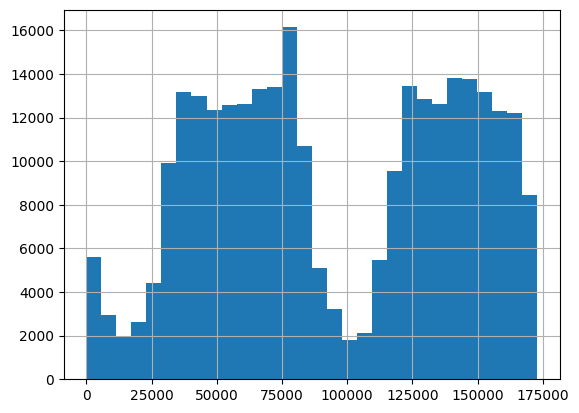

In [4]:
df["Time"].hist(bins=30)

The reason two high frequency areas are shown is because this data was recorded over two days, so the two dips are most likely the early morning on each day, with the tops of the curves representing the highest frequency times during the day. 

Although the time is a good variable to include, it will need to be scaled in order to be more useful for training models. 

#### Amount

The Amount column is simply the transaction amount. Below, the top 10 amounts are shown along with a histogram of the Amount column: 

274771    25691.16
58465     19656.53
151296    18910.00
46841     12910.93
54018     11898.09
169457    11789.84
284249    10199.44
227921    10000.00
74699      8790.26
245474     8787.00
Name: Amount, dtype: float64


<Axes: >

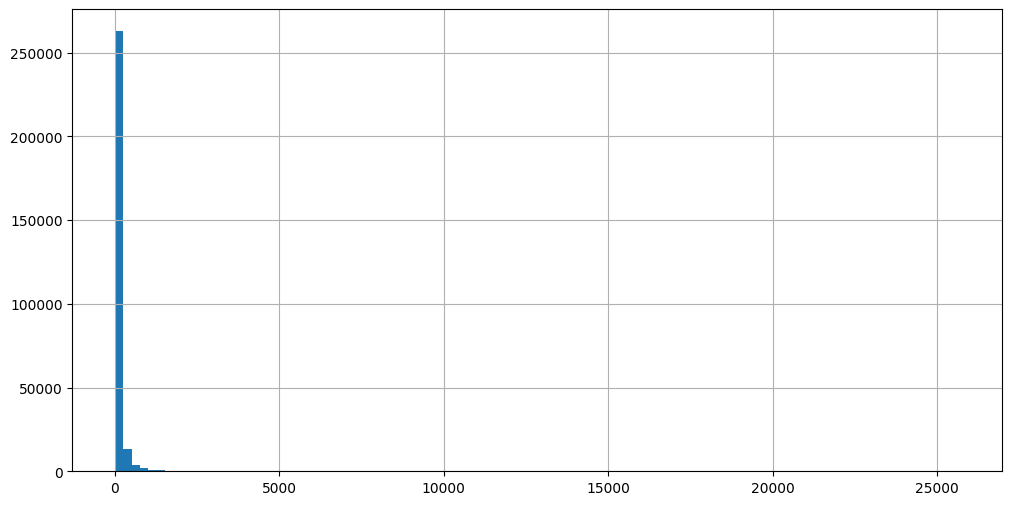

In [5]:
print(df["Amount"].sort_values(ascending=False).head(10))

df["Amount"].hist(bins=100, figsize=(12, 6))

The histogram above shows that the majority of transactions were relatively small amounts, with a few large transactions causing the chart to display large value along the X-axis. The 10 highest-amount transactions are shown above the chart, with the only 8 being 10,000 or greater. Scaling will help even out this features and counteract skewing of the model. 

#### Class

The Class column represents the target. Below, a function is defined to plot the negative and positive classes: 

In [6]:
def plot_bin(y_in): # Function definition
    # y_in = df["Class"]
    bin_count = np.bincount(y_in)
    count_df = pd.DataFrame(data={"0": bin_count[0], "1": bin_count[1]}, index=[0])

    count_df.plot(kind="bar")
    return count_df

,0,1
0,284315,492


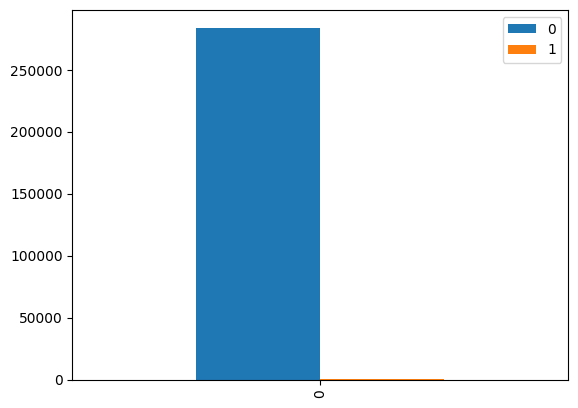

In [7]:
plot_bin(df["Class"]) # Function call

In total, over 284,000 transactions were legitimate, with only 492 being fraudulent. While its good that so little fraud is happening proportionally to the overall number of transactions, this makes it much harder to train a model to detect fraud. This issue will be addressed in the preprocessing section.

While features V1-V28 could be plotted, they have already been transformed and scaled to protect customer information, so they will be used as is going forward. 

## Preprocessing

Below, some preprocessing steps are taken to prepare the data for use in a model. First, the features and target are defined: 

In [8]:
X, y = df.drop("Class", axis=1), df["Class"]

X.shape, y.shape

((284807, 30), (284807,))

### Splitting

While the majority of the data will be utilized by the model to learn the underlying patterns, some data needs to be set aside in order to similuate real world data. Below, an 80-10-10 train-validation-test split is performed: 

In [9]:
# 80% train
# 10% validation
# 10% test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42) 
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test, random_state=42) 

X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_val.shape, y_test.shape

((256326, 30), (14241, 30), (14240, 30), (256326,), (14240,), (14241,))

### Scaling

The Time and Amount columns are scaled so outlying data doesn't skew the model's predictions. This should help the models make more accurate predictions. 

In [10]:
scaler = StandardScaler()
scaler.fit(X_train[["Time", "Amount"]])

X_train[["Time", "Amount"]] = scaler.transform(X_train[["Time", "Amount"]])
X_val[["Time", "Amount"]] = scaler.transform(X_val[["Time", "Amount"]])
X_test[["Time", "Amount"]] = scaler.transform(X_test[["Time", "Amount"]])

### Oversampling

Because the target contains a much greater number of negative instances, the training data needs to be oversampled in order for the models to learn the patterns when the fraud occurs. Below, random oversampling is used to transform the training dataset. 

> [Random Oversampling](https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis) involves supplementing the training data with multiple copies of some of the minority classes.

In [11]:
ros = RandomOverSampler(random_state=42)
X_train, y_train = ros.fit_resample(X_train, y_train)

,0,1
0,255883,255883


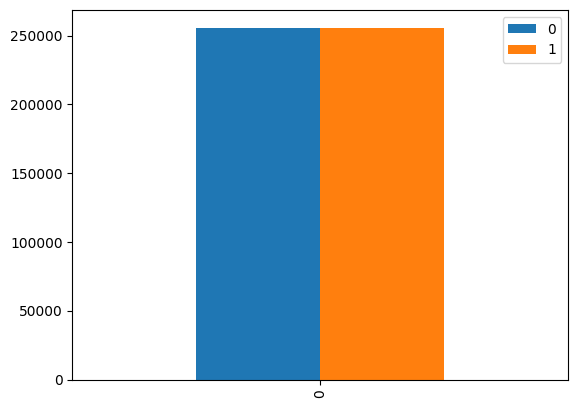

In [12]:
plot_bin(y_train)

After oversampling, there are an equal amount of negative and positive instances. 

Now that the data has been prepared, it can be used to train and test models. 

## Model Building

In total 3 models will be built with slightly different compositions. All will incorporate multiple dense layers, with batch normalization and dropout. 

### Metrics

Because this is a binary classification problem, some basic terminology is defined below: 

* True Positive (TP): the true instances that are correctly classified as true
* False Positive (FP): the false instances that are incorrectly classified as true
* True Negative (TN): the false instances that are correctly classified as false
* False Negatives (FN): the true instances that are incorrectly classified as false

The goal of classification is to classify all instances as either true positives or true negatives, while getting as few false positives and false negatives as possible. The metrics used in reaching this goal are defined below: 
* Accuracy: the overall percentage of instances that were correct: (TP + TN) / Total
* Precision: the percentage of positive <i>predictions</i> that were correct: TP / (TP + FP)
* Recall: the percentage of positive <i>instances</i> that were predicted to be positive: TP / (TP + FN)

In each metric, a higher score is better. However, there are can be trade-offs between precision and recall. For the models below, a balance between precision and recall is the goal (along with high accuracy). 

Now that the background has been explained, the model building can begin. 

#### Model 1

The first model contains two 256-unit dense layers with dropout layers of 0.35, which are fed to a dense 32-unit layer and onto the output. The Nadam optimizer is used with a learning rate of 0.0001.

In [13]:
tf.random.set_seed(42)
np.random.seed(42)

model1 = Sequential([

    InputLayer(X_train.shape[1:]),
    
    Dense(256, activation="relu"),
    BatchNormalization(),
    Dropout(0.35),

    Dense(256, activation="relu"),
    BatchNormalization(),
    Dropout(0.35),
    
    Dense(32, activation="relu"),
    Dense(1, activation="sigmoid")
])

model1.compile(loss=BinaryCrossentropy(), optimizer=Nadam(learning_rate=0.0001), metrics=["accuracy", "precision", "recall"])
model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
15993/15993 ━━━━━━━━━━━━━━━━━━━━ 37s 2ms/step - accuracy: 0.9522 - loss: 0.1186 - precision: 0.9661 - recall: 0.9366 - val_accuracy: 0.9934 - val_loss: 0.0206 - val_precision: 0.1875 - val_recall: 0.8750
Epoch 2/100
15993/15993 ━━━━━━━━━━━━━━━━━━━━ 34s 2ms/step - accuracy: 0.9931 - loss: 0.0210 - precision: 0.9913 - recall: 0.9951 - val_accuracy: 0.9966 - val_loss: 0.0138 - val_precision: 0.3134 - val_recall: 0.8750
Epoch 3/100
15993/15993 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - accuracy: 0.9964 - loss: 0.0118 - precision: 0.9951 - recall: 0.9977 - val_accuracy: 0.9971 - val_loss: 0.0124 - val_precision: 0.3559 - val_recall: 0.8750
Epoch 4/100
15993/15993 ━━━━━━━━━━━━━━━━━━━━ 37s 2ms/step - accuracy: 0.9977 - loss: 0.0084 - precision: 0.9967 - recall: 0.9987 - val_accuracy: 0.9976 - val_loss: 0.0107 - val_precision: 0.4038 - val_recall: 0.8750
Epoch 5/100
15993/15993 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - accuracy: 0.9982 - loss: 0.0066 - precision: 0.9975 - recall: 0.9989 - val_a

The final validation metrics for `model1` were: 
* Accuracy: 0.99
* Precision: 0.86
* Recall: 0.83

Below, `model1` is scored on the testing set: 

In [14]:
model1.evaluate(X_test, y_test)

446/446 ━━━━━━━━━━━━━━━━━━━━ 1s 937us/step - accuracy: 0.9993 - loss: 0.0123 - precision: 0.7828 - recall: 0.8533       


[0.0062684593722224236,
 0.9995084404945374,
 0.8214285969734192,
 0.9200000166893005]

The accuracy was near perfect, but precision and recall were not quite as good. Although the latter two metrics are not ideal, the model did fairly well on the testing data. 

#### Model 2

The second model contains four 256-unit dense layers with dropout layers of 0.35, which are fed to a dense 32-unit layer and onto the output. Once again, the Nadam optimizer is used, but with a learning rate of 0.001 instead of 0.0001. The larget network should hopefully be able to learn more complex relationships in the data. 

In [15]:
tf.random.set_seed(42)
np.random.seed(42)

model2 = Sequential([

    InputLayer(X_train.shape[1:]),
    
    Dense(256, activation="relu"),
    BatchNormalization(),
    Dropout(0.35),

    Dense(256, activation="relu"),
    BatchNormalization(),
    Dropout(0.35),

    Dense(256, activation="relu"),
    BatchNormalization(),
    Dropout(0.35),

    Dense(256, activation="relu"),
    BatchNormalization(),
    Dropout(0.35),

    Dense(32, activation="relu"),
    Dense(1, activation="sigmoid")
])

model2.compile(loss=BinaryCrossentropy(), optimizer=Nadam(learning_rate=0.001), metrics=["accuracy", "precision", "recall"])
model2.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
15993/15993 ━━━━━━━━━━━━━━━━━━━━ 45s 3ms/step - accuracy: 0.9713 - loss: 0.0735 - precision: 0.9718 - recall: 0.9708 - val_accuracy: 0.9952 - val_loss: 0.0147 - val_precision: 0.2442 - val_recall: 0.8750
Epoch 2/100
15993/15993 ━━━━━━━━━━━━━━━━━━━━ 43s 3ms/step - accuracy: 0.9954 - loss: 0.0159 - precision: 0.9940 - recall: 0.9969 - val_accuracy: 0.9968 - val_loss: 0.0116 - val_precision: 0.3226 - val_recall: 0.8333
Epoch 3/100
15993/15993 ━━━━━━━━━━━━━━━━━━━━ 43s 3ms/step - accuracy: 0.9969 - loss: 0.0111 - precision: 0.9958 - recall: 0.9981 - val_accuracy: 0.9980 - val_loss: 0.0085 - val_precision: 0.4468 - val_recall: 0.8750
Epoch 4/100
15993/15993 ━━━━━━━━━━━━━━━━━━━━ 43s 3ms/step - accuracy: 0.9977 - loss: 0.0090 - precision: 0.9967 - recall: 0.9987 - val_accuracy: 0.9980 - val_loss: 0.0082 - val_precision: 0.4565 - val_recall: 0.8750
Epoch 5/100
15993/15993 ━━━━━━━━━━━━━━━━━━━━ 46s 3ms/step - accuracy: 0.9980 - loss: 0.0078 - precision: 0.9973 - recall: 0.9988 - val_a

The final validation metrics for `model2` were: 
* Accuracy: 0.99
* Precision: 0.71 
* Recall: 0.83  

Below, `model2` is scored on the testing set: 

In [16]:
model2.evaluate(X_test, y_test)

446/446 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9993 - loss: 0.0116 - precision: 0.7670 - recall: 0.8533     


[0.016008902341127396,
 0.9992977976799011,
 0.7419354915618896,
 0.9200000166893005]

Once again, the accuracy was nearly perfect, with precision dropping and recall remaining the same. Its still not a bad model, but not quite as good as `model1`. 

#### Model 3

The third and final model once again contains four 256-unit dense layers which are fed to a dense 32-unit layer and onto the output. However, this time the dropout layers are reduced slightly to 0.3. The SGD optimizer is used in place of Nadam, but the learning rate of 0.001 is maintained.

In [17]:
tf.random.set_seed(42)
np.random.seed(42)

model3 = Sequential([

    InputLayer(X_train.shape[1:]),
    Dense(256, activation="relu"),
    BatchNormalization(),
    Dropout(0.3),

    Dense(256, activation="relu"),
    BatchNormalization(),
    Dropout(0.25),

    Dense(128, activation="relu"),
    BatchNormalization(),
    Dropout(0.3),

    Dense(128, activation="relu"),
    BatchNormalization(),
    Dropout(0.3),

    Dense(32, activation="relu"),
    Dense(1, activation="sigmoid")
])

model3.compile(loss=BinaryCrossentropy(), optimizer=SGD(learning_rate=0.001), metrics=["accuracy", "precision", "recall"])
model3.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
15993/15993 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - accuracy: 0.8933 - loss: 0.2603 - precision: 0.9301 - recall: 0.8480 - val_accuracy: 0.9837 - val_loss: 0.0591 - val_precision: 0.0873 - val_recall: 0.9167
Epoch 2/100
15993/15993 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step - accuracy: 0.9523 - loss: 0.1200 - precision: 0.9601 - recall: 0.9438 - val_accuracy: 0.9821 - val_loss: 0.0493 - val_precision: 0.0800 - val_recall: 0.9167
Epoch 3/100
15993/15993 ━━━━━━━━━━━━━━━━━━━━ 31s 2ms/step - accuracy: 0.9631 - loss: 0.0924 - precision: 0.9662 - recall: 0.9600 - val_accuracy: 0.9840 - val_loss: 0.0398 - val_precision: 0.0887 - val_recall: 0.9167
Epoch 4/100
15993/15993 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step - accuracy: 0.9703 - loss: 0.0761 - precision: 0.9708 - recall: 0.9699 - val_accuracy: 0.9851 - val_loss: 0.0340 - val_precision: 0.0913 - val_recall: 0.8750
Epoch 5/100
15993/15993 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step - accuracy: 0.9747 - loss: 0.0649 - precision: 0.9733 - recall: 0.9762 - val_a

The final validation metrics for `model3` were: 
* Accuracy: 0.99
* Precision: 0.70
* Recall: 0.79

Below, `model3` is scored on the testing set: 

In [18]:
model3.evaluate(X_test, y_test)

446/446 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9992 - loss: 0.0075 - precision: 0.7212 - recall: 0.8533        


[0.006295042112469673, 0.9992275834083557, 0.71875, 0.9200000166893005]

The accuracy and recall results remain the same, with the precision score being the lowest out of all three models. 

> Note that the testing recall score is the same between all three models. This is due to the fact that the validation and testing sets were not oversampled, resulting in each having relatively few positive instances for the models to predict.


### Summary of Models

In the end, `model1` performed the best out of the three. Based on the test data, it is reasonable to assume that, in the real world, the model would catch the majority of fraud, while also keeping false positives positives to a minimum. 

## Application

Now that `model1` has been trained, it can be used in real world programs. However, it first needs to be exported to a `.keras` file, which can be called by other Python programs: 

In [19]:
model1.save("model1.keras")

## Conclusion

The world of finance has grown rapidly in the internet age, bringing with it new opportunities for fraud. With the age of AI upon us, new technologies will inevitably be used by malicious actors to find new ways to circumvent security measures and cause irreparable damage to innocent people. The good news is that AI can also be used to help prevent fraudsters' attempts at stealing from customers and companies alike, creating a new era of security for in a sector that affects so many lives. 